<a href="https://colab.research.google.com/github/JLuceroVasquez/clasificacion-validacion-de-modelos-y-metricas/blob/main/Clasificacion_validacion_y_metricas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='dark'>**Clasificación: Validación de modelos y métricas de evaluación**</h1>

### Proyecto

Una empresa de financiamiento de automóviles está atravesando una situación complicada, con una alta demanda para una flota reducida de vehículos y un alto número de morosos, lo que está generando grandes pérdidas para la empresa.

Nosotros fuimos contratados para buscar mejoras en la identificación de morosos. El análisis de los clientes actualmente se realiza de forma manual, cliente por cliente, lo que consume mucho tiempo y, aun así, la detección de morosos es muy imprecisa.

Nuestra tarea es utilizar los datos proporcionados por la empresa para **clasificar** a los clientes en cumplidores y morosos.

In [149]:
#Para la manipulación de datos
import pandas as pd
import numpy as np

#Para la división en conjunto de datos
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold #Para dividir los datos de (entrenamiento y validación) en K-subgrupos
from sklearn.model_selection import StratifiedKFold #Para dividir los datos de (entrenamiento y validación) en K-subgrupos de forma estratificada
from sklearn.model_selection import LeaveOneOut #Para dividir los datos en 1 para validación y los demás para entrenamiento
from sklearn.model_selection import cross_validate #Para realizar la validación cruzada con cada subgrupo
from sklearn.model_selection import cross_val_score #Para mostrar únicamente las métricas de la validación cruzada

#Para el balanceo de categorías en la variable Y
from imblearn.over_sampling import SMOTE #Técnica de oversampling SMOTE
from imblearn.under_sampling import NearMiss #Técnica de undersampling NearMiss
from imblearn.combine import SMOTEENN #Técnica que combina el método oversampling SMOTE y undersampling ENN
from imblearn.pipeline import Pipeline as imbpipeline #Para crear un pipeline (secuencia de pasos) que permita entrenar un modelo con datos balanceados, y validarlo por separado con datos desbalanceados

#Para en el entrenamiento de modelos ML
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#Para la evaluación de modelos ML: Matriz de confusión
from sklearn.metrics import confusion_matrix #Para obtener los valores de la matriz de confusión
from sklearn.metrics import ConfusionMatrixDisplay #Para visualizar la matriz de confusión
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score #Para el cálculo de métricas que cuantifiquen el error tipo 1 y 2 de la matriz de confusión

#Para la evaluación de modelos ML: Curva ROC
from sklearn.metrics import RocCurveDisplay #Para visualizar la curva ROC
from sklearn.metrics import roc_auc_score #Para el cálculo de la curva ROC

#Para la evaluación de modelos ML: Curva de precisión x sensibilidad
from sklearn.metrics import PrecisionRecallDisplay #Para visualizar la curva de precisión x sensibilidad
from sklearn.metrics import average_precision_score #Para el cálculo de la precisión promedio respecto a distintos valores de sensibilidad

#Para la evaluación de modelos ML: Informe de clasificación
from sklearn.metrics import classification_report #Para visualizar las métricas de precisión, recall y F1 por cada categoría, y sus promedios

## <font color='dark'>Clasificando los datos</h1>

### Creando un modelo inicial

In [79]:
'''
import chardet
with open('/content/prestacar.csv','rb') as f:
  diccionario = chardet.detect(f.read())
  encode = diccionario['encoding']

print(encode)
'''

"\nimport chardet\nwith open('/content/prestacar.csv','rb') as f:\n  diccionario = chardet.detect(f.read())\n  encode = diccionario['encoding']\n\nprint(encode)\n"

In [80]:
url = 'https://github.com/JLuceroVasquez/clasificacion-validacion-de-modelos-y-metricas/raw/refs/heads/main/prestacar.csv'
datos = pd.read_csv(url, encoding='utf-8') #Se empleó utf-8 para importar correctamente el nombre de las columnas
datos.head()

,ingresos_cliente,anualidad_prestamo,años_casa_propia,telefono_trab,evaluacion_ciudad,score_1,score_2,score_3,score_social,cambio_telefono,moroso
0,12600.0,3569.400000,12.157324,1,2.0,0.057153,0.527227,0.513171,0.117428,2545.0,0
1,9000.0,2722.188351,7.000000,0,2.0,0.657661,0.285898,0.614414,0.222700,495.0,0
2,15750.0,4477.500000,12.000000,0,2.0,0.501213,0.695423,0.513171,0.117428,1212.0,0
3,9000.0,1309.050000,12.157324,0,3.0,0.501213,0.155973,0.513171,0.117428,515.0,0
4,7650.0,1125.000000,12.157324,0,2.0,0.294328,0.152076,0.513171,0.117428,162.0,0


In [81]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54025 entries, 0 to 54024
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ingresos_cliente    54025 non-null  float64
 1   anualidad_prestamo  54025 non-null  float64
 2   años_casa_propia    54025 non-null  float64
 3   telefono_trab       54025 non-null  int64  
 4   evaluacion_ciudad   54025 non-null  float64
 5   score_1             54025 non-null  float64
 6   score_2             54025 non-null  float64
 7   score_3             54025 non-null  float64
 8   score_social        54025 non-null  float64
 9   cambio_telefono     54025 non-null  float64
 10  moroso              54025 non-null  int64  
dtypes: float64(9), int64(2)
memory usage: 4.5 MB


In [82]:
#Separando las variables explicativas de la variable de respuesta
X = datos.drop(columns='moroso')
y = datos['moroso']

#Entrenamiento y evaluación del modelo de arbol clasificador
modelo_arbol = DecisionTreeClassifier()
modelo_arbol.fit(X, y)
print(f'El modelo de árbo tiene una exactitud de {modelo_arbol.score(X, y)}')

El modelo de árbo tiene una exactitud de 1.0


### Validando el modelo

Evaluar el modelo con los mismos datos utilizados en el entrenamiento no es recomendable. Es necesario que la evaluación se realice con datos independientes.  

Evaluar el modelo con los propios datos de entrenamiento sería equivalente a entregar un examen con las preguntas y las respuestas a una persona y, al momento de evaluarla nuevamente, entregarle un examen con las mismas preguntas y opciones. Se espera que esa persona obtenga un buen resultado, ya que ya ha visto las respuestas y ha memorizado el resultado. Esto es diferente de haber aprendido la materia a partir de ese examen y luego presentar una prueba con contenido similar y obtener un resultado positivo.  

Con el objetivo de verificar la capacidad de generalización de un modelo, debemos dividir el conjunto de datos en tres partes: datos de entrenamiento, validación y prueba.  

- El **conjunto de entrenamiento** se utiliza para entrenar los modelos. A partir de este conjunto, los modelos identifican patrones en los datos.  

- El **conjunto de validación** se emplea para evaluar el desempeño de diferentes modelos con datos nuevos que no fueron utilizados en el entrenamiento.  

- El **conjunto de prueba** se mantiene separado desde el inicio para simular datos del mundo real. No se utiliza en ninguna etapa del entrenamiento ni de la validación, sirviendo como una estimación de la capacidad del modelo elegido para generalizar y predecir nuevos datos.

<a href="https://ibb.co/9H2Z1HZ5"><img src="https://i.ibb.co/0yZs6ysb/datos-train-test.png" alt="datos-train-test" border="0"></a>

In [83]:
#Se divide los datos en 3 conjuntos: Entrenamiento(64% = 75%*85%), validación(21% = 25%*85%), prueba(15%)
X, X_test, y, y_test = train_test_split(X, y, test_size=0.15, random_state=5, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=5, stratify=y)

In [84]:
#Entrenamiento y validación del modelo de árbol con profundida exahustiva
modelo_arbol = DecisionTreeClassifier(random_state=2)
modelo_arbol.fit(X_train, y_train)
print(f'El modelo de árbol con datos de entrenamiento tiene una exactitud de {modelo_arbol.score(X_train, y_train)}')
print(f'El modelo de árbol con datos de validación tiene una exactitud de {modelo_arbol.score(X_val, y_val)}')

El modelo de árbol con datos de entrenamiento tiene una exactitud de 1.0
El modelo de árbol con datos de validación tiene una exactitud de 0.847312951833464


In [85]:
#Entrenamiento y validación del modelo de árbol con 10 niveles de profundidad
modelo_arbol = DecisionTreeClassifier(max_depth=10, random_state=2)
modelo_arbol.fit(X_train, y_train)
print(f'El modelo de árbol con datos de entrenamiento tiene una exactitud de {modelo_arbol.score(X_train, y_train)}')
print(f'El modelo de árbol con datos de validación tiene una exactitud de {modelo_arbol.score(X_val, y_val)}')

El modelo de árbol con datos de entrenamiento tiene una exactitud de 0.9206445993031359
El modelo de árbol con datos de validación tiene una exactitud de 0.9055831373573731


### Evaluando el modelo

In [86]:
y_pred_val = modelo_arbol.predict(X_val)

In [87]:
matriz_confusion = confusion_matrix(y_val, y_pred_val)
matriz_confusion

array([[10355,   124],
       [  960,    42]])

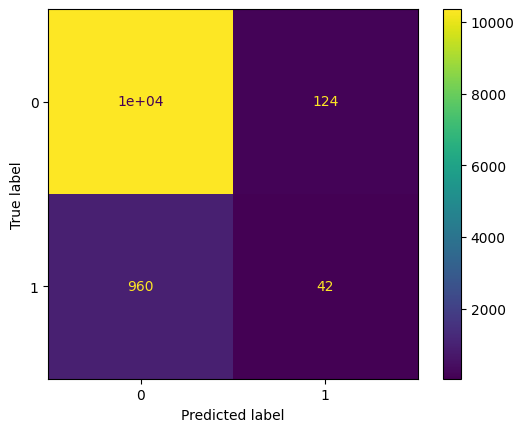

In [88]:
'''
El siguiente código devuelve un objeto tipo AxesSubplot. El punto y coma
silencia la salida textual, solicitando a Jupyter que muestre únicamente la
visualización del gráfico.
'''
visualizacion = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion)
visualizacion.plot();

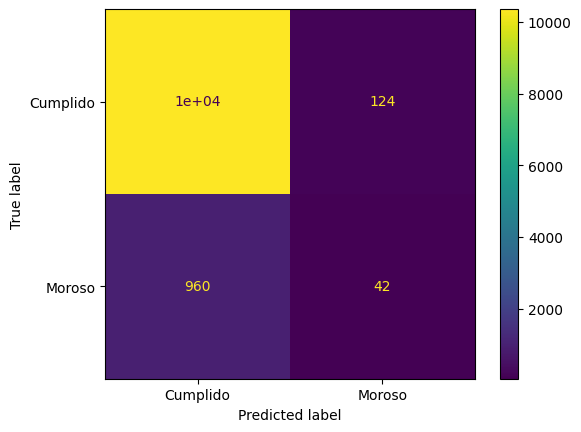

In [89]:
visualizacion = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion, display_labels=['Cumplido','Moroso'])
visualizacion.plot();

### Desafío 1 - aula 1
Utilizamos durante la clase el algoritmo de árbol de decisión, pero la biblioteca Scikit-Learn tiene varios otros métodos de clasificación que pueden ser utilizados en nuestro proyecto. Como desafío, utiliza el algoritmo Random Forest para crear un modelo y evaluar el desempeño con la precisión y la matriz de confusión, y compara los resultados con el resultado del árbol de decisión.

Como un consejo, revisa la documentación del algoritmo [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier).

#### Entrenamiento del modelo

In [90]:
modelo_randomforest = RandomForestClassifier(max_depth=10, random_state=2)
modelo_randomforest.fit(X_train, y_train)
print(f'El modelo de randomforest con datos de entrenamiento tiene una exactitud de {modelo_randomforest.score(X_train, y_train)}')
print(f'El modelo de randomforest con datos de validación tiene una exactitud de {modelo_randomforest.score(X_val, y_val)}')

El modelo de randomforest con datos de entrenamiento tiene una exactitud de 0.9151567944250871
El modelo de randomforest con datos de validación tiene una exactitud de 0.9127253723543245


#### Evaluando del modelo

In [91]:
y_pred_val = modelo_randomforest.predict(X_val)
matriz_confusion = confusion_matrix(y_val, y_pred_val)

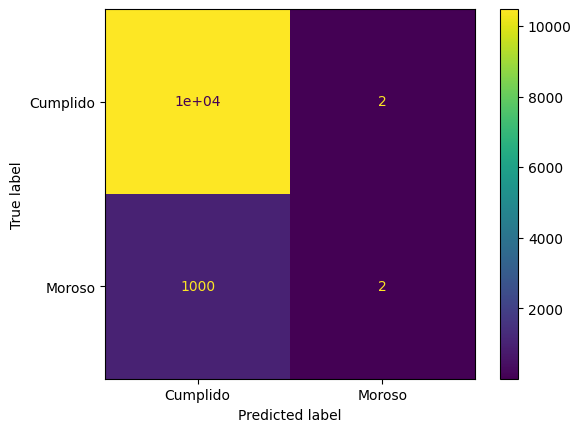

In [92]:
visualizacion = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion, display_labels=['Cumplido','Moroso'])
visualizacion.plot();

### Desafío 2 - aula 1
Vamos a practicar el contenido que se presentó en la clase a partir de algunas actividades, pero utilizando un conjunto de datos diferente con datos de pacientes a ser diagnosticados con diabetes o no. Los desafíos siguen una secuencia de tareas, sirviendo como un proyecto secundario. Para realizar los desafíos, descarga la base de datos desde este [enlace](https://github.com/alura-es-cursos/2162-clasificacion-validacion-de-modelos-y-metricas/blob/desafios/diabetes.csv).

1. Para la construcción de un modelo de machine learning se necesitan datos. Como tarea inicial, realiza la lectura de la base de datos de diabetes y divide los datos en variables explicativas y variable objetivo (x e y). La variable objetivo es la columna que quieres clasificar, que contiene la información de si el paciente tiene o no diabetes. Las variables explicativas son todas las columnas excepto la de diabetes. La separación de los datos se puede hacer con la selección de columnas con pandas.

2. Una etapa muy importante en proyectos de clasificación es la validación de los modelos, para identificar si hay una generalización del modelo para datos nuevos. Realiza la división de los datos entre entrenamiento, validación y prueba. Utiliza el 5% de los datos para prueba y con el resto, deja el 25% para validación. En el momento de la separación, usa el parámetro stratify a partir de la variable objetivo para mantener la proporción de los datos.

3. La etapa de modelado de datos consiste en utilizar un algoritmo capaz de identificar patrones en los datos y clasificar los valores. A partir del modelo es posible extraer una tasa de acierto para entender su desempeño. Crea 2 modelos utilizando los algoritmos DecisionTreeClassifier y RandomForestClassifier y evalúa la precisión de entrenamiento y prueba, eligiendo el valor 3 para el parámetro max_depth del algoritmo DecisionTreeClassifier y el valor 2 para el max_depth del algoritmo RandomForestClassifier, para que los modelos no se especialicen demasiado en el patrón de los datos de entrenamiento.

4. La tasa de acierto generalmente no proporciona información suficiente para entender el comportamiento del modelo. La matriz de confusión es una herramienta más completa, capaz de proporcionar los aciertos y errores del modelo para cada clase. Construye una matriz de confusión para cada uno de los modelos para evaluar el desempeño de la predicción. Para construir la matriz, usa el método predict para generar las predicciones de los valores y comparar con los valores reales de la base de datos.

#### Importación de los datos

In [93]:
'''
import chardet
with open('/content/diabetes.csv','rb') as f:
  diccionario = chardet.detect(f.read())
  encode = diccionario['encoding']

print(encode)
'''

"\nimport chardet\nwith open('/content/diabetes.csv','rb') as f:\n  diccionario = chardet.detect(f.read())\n  encode = diccionario['encoding']\n\nprint(encode)\n"

In [94]:
url_desafio = 'https://github.com/JLuceroVasquez/clasificacion-validacion-de-modelos-y-metricas/raw/refs/heads/main/desafio/diabetes.csv'
datos_desafio = pd.read_csv(url_desafio, encoding='ascii')
datos_desafio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394 entries, 0 to 393
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   glicemia                  394 non-null    int64  
 1   presion_sanguinea         394 non-null    int64  
 2   grasa_subcutanea_triceps  394 non-null    int64  
 3   insulina                  394 non-null    float64
 4   imc                       394 non-null    float64
 5   diabetes                  394 non-null    int64  
dtypes: float64(2), int64(4)
memory usage: 18.6 KB


In [95]:
X_d = datos_desafio.drop(columns='diabetes')
y_d = datos_desafio.diabetes

#### División en 3 conjuntos de datos

In [96]:
X_d, X_test_d, y_d, y_test_d = train_test_split(X_d, y_d, test_size=0.05, random_state=5, stratify=y_d)
X_train_d, X_val_d, y_train_d, y_val_d = train_test_split(X_d, y_d, test_size=0.25, random_state=5, stratify=y_d)

#### Entrenamiento de 2 modelos de clasificación

In [97]:
modelo_arbol_d = DecisionTreeClassifier(max_depth=3, random_state=2)
modelo_arbol_d.fit(X_train_d, y_train_d)
print(f'El modelo de árbol con datos de entrenamiento tiene una exactitud de {modelo_arbol_d.score(X_train_d, y_train_d)}')
print(f'El modelo de árbol con datos de validación tiene una exactitud de {modelo_arbol_d.score(X_val_d, y_val_d)}')

El modelo de árbol con datos de entrenamiento tiene una exactitud de 0.7571428571428571
El modelo de árbol con datos de validación tiene una exactitud de 0.776595744680851


In [98]:
modelo_randomforest_d = RandomForestClassifier(max_depth=2, random_state=2)
modelo_randomforest_d.fit(X_train_d, y_train_d)
print(f'El modelo de randomforest con datos de entrenamiento tiene una exactitud de {modelo_randomforest_d.score(X_train_d, y_train_d)}')
print(f'El modelo de randomforest con datos de validación tiene una exactitud de {modelo_randomforest_d.score(X_val_d, y_val_d)}')

El modelo de randomforest con datos de entrenamiento tiene una exactitud de 0.7357142857142858
El modelo de randomforest con datos de validación tiene una exactitud de 0.6914893617021277


#### Matriz de confusión

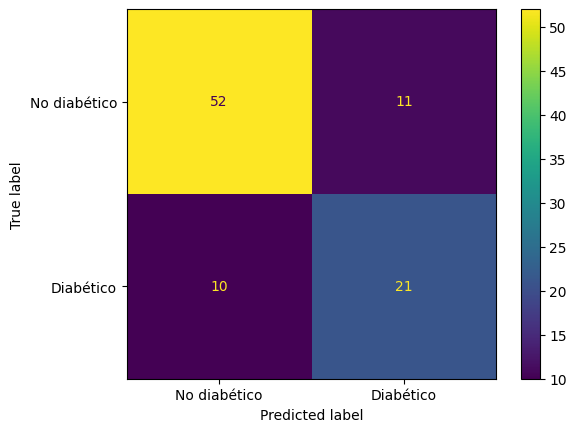

In [99]:
y_pred_val_d = modelo_arbol_d.predict(X_val_d)
matriz_confusion = confusion_matrix(y_val_d, y_pred_val_d)
visualizacion = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion, display_labels=['No diabético','Diabético'])
visualizacion.plot();

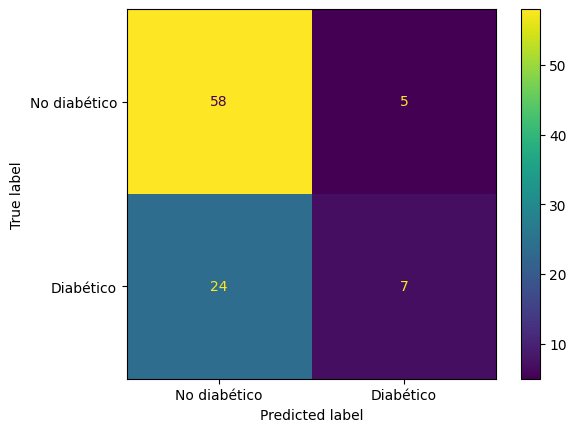

In [100]:
y_pred_val_d = modelo_randomforest_d.predict(X_val_d)
matriz_confusion = confusion_matrix(y_val_d, y_pred_val_d)
visualizacion = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion, display_labels=['No diabético','Diabético'])
visualizacion.plot();

## <font color='dark'>Métricas de evaluación</h1>

### Exactitud, precisión y recall (sensibilidad).

<a href="https://ibb.co/351SbY7t"><img src="https://i.ibb.co/wZypqrRD/matriz-confusion.png" alt="matriz-confusion" border="0"></a>

<a href="https://imgbb.com/"><img src="https://i.ibb.co/6Jp6rKyC/Captura-de-tela-2025-03-22-120744.png" alt="Captura-de-tela-2025-03-22-120744" border="0"></a>

In [101]:
#Se evaluará el modelo de árbol por presentar menos falsos negativos (falsos no morosos)
y_pred_val = modelo_arbol.predict(X_val)

In [102]:
accuracy_modelo_arbol = "{:.4f}".format(accuracy_score(y_val, y_pred_val))
print(f'La exactitud del modelo de árbol es {accuracy_modelo_arbol}')

La exactitud del modelo de árbol es 0.9056


In [103]:
precision_modelo_arbol = "{:.4f}".format(precision_score(y_val, y_pred_val))
print(f'La precisión del modelo de árbol es {precision_modelo_arbol}')

La precisión del modelo de árbol es 0.2530


In [104]:
recall_modelo_arbol = "{:.4f}".format(recall_score(y_val, y_pred_val))
print(f'La sensibilidad del modelo de árbol es {recall_modelo_arbol}')

La sensibilidad del modelo de árbol es 0.0419


In [105]:
f1_modelo_arbol = "{:.4f}".format(f1_score(y_val, y_pred_val))
print(f'El puntaje F1 d del modelo de árbol es {f1_modelo_arbol}')

El puntaje F1 d del modelo de árbol es 0.0719


### Curva ROC

In [106]:
from IPython.display import Image
Image(url='https://raw.githubusercontent.com/dariyasydykova/open_projects/master/ROC_animation/animations/cutoff.gif')

Fuente: [paulvanderlaken.com](https://paulvanderlaken.com/2019/08/16/roc-auc-precision-and-recall-visually-explained/)




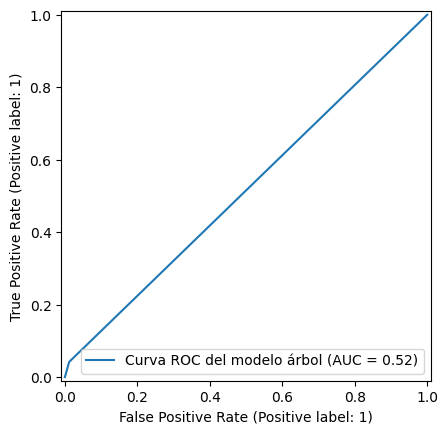

In [107]:
RocCurveDisplay.from_predictions(y_val, y_pred_val, name='Curva ROC del modelo árbol');

In [108]:
print(f'El área bajo la curva ROC del modelo de árbol es: {roc_auc_score(y_val, y_pred_val):.4f}')

El área bajo la curva ROC del modelo de árbol es: 0.5150


### Curva de  precisión x sensibilidad

In [109]:
Image(url='https://paulvanderlaken.com/wp-content/uploads/2019/08/roc.gif')

Fuente: [paulvanderlaken.com](https://paulvanderlaken.com/2019/08/16/roc-auc-precision-and-recall-visually-explained/)


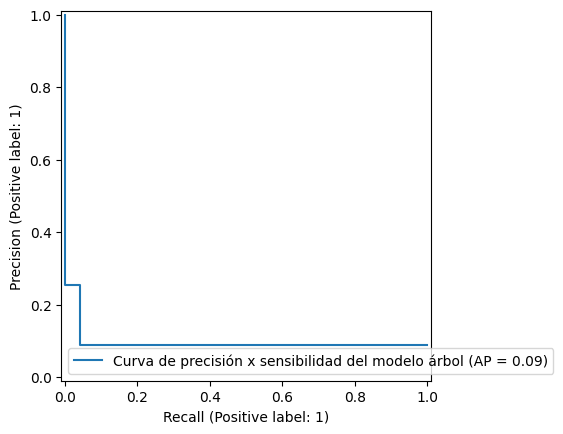

In [110]:
PrecisionRecallDisplay.from_predictions(y_val, y_pred_val, name='Curva de precisión x sensibilidad del modelo árbol');

In [111]:
print(f'La precisión promedio para distintos valores de sensibilidad en el modelo de árbol es: {average_precision_score(y_val, y_pred_val)}')

La precisión promedio para distintos valores de sensibilidad en el modelo de árbol es: 0.09422170515363755


### Informe de métricas

Del reporte generado, con los 11481 datos del conjunto de validación, se observa que el modelo no arroja predicciones muy buenas para la categoría positiva (1) que representa a los morosos. Esto se refleja en que aunque la exactitud del modelo es 0.91, su f1-score para 1 es de 0.07.

In [112]:
reporte = classification_report(y_val, y_pred_val)
print(reporte)

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     10479
           1       0.25      0.04      0.07      1002

    accuracy                           0.91     11481
   macro avg       0.58      0.52      0.51     11481
weighted avg       0.86      0.91      0.87     11481



### Desafío - aula 2

 Los desafíos siguen una secuencia de tareas, sirviendo como un proyecto secundario. Para realizar los desafíos, descarga la base de datos desde este [enlace](https://github.com/alura-es-cursos/2162-clasificacion-validacion-de-modelos-y-metricas/blob/desafios/diabetes.csv).

Estos desafíos dependen del modelo generado en los desafíos de la clase 1.

1. Para una evaluación completa de un modelo de clasificación, podemos explorar métricas que evalúan la tasa de acierto general y también para cada clase de la variable objetivo de forma individual. Extrae las métricas de precisión, recall, precisión y F1-Score de los modelos de clasificación generados en el desafío de la clase 1. La biblioteca Scikit-Learn tiene funciones para calcular cada una de las métricas, solo necesitas importar y utilizar como parámetros los valores reales y previstos por el modelo.

2. Además de métricas numéricas, se pueden explorar gráficos para evaluar el rendimiento de un modelo y comprender si puede diferenciar bien una clase de otra. Obtén la curva ROC y la métrica AUC de los modelos de clasificación generados en el desafío de la clase 1, comparando las curvas en el mismo gráfico. La curva ROC se puede generar usando el método RocCurveDisplay.from_predictions.

3. Además de la curva ROC, la curva de precisión x recall se puede usar para evaluar el rendimiento de modelos, siendo más interesante para datos desbalanceados. Obtén la curva de precisión x recall y la métrica AP de los modelos de clasificación generados en el desafío de la clase 1, comparando las curvas en el mismo gráfico. La curva de precisión x recall se puede generar usando el método PrecisionRecallDisplay.from_predictions.

4. Un resumen de las principales métricas de clasificación puede ser muy útil para resumir la información y generar insights de forma rápida. Genera los informes de métricas de los modelos de clasificación construidos en el desafío de la clase 1. El informe de métricas se puede generar a partir de la función classification_report de la biblioteca Scikit-Learn.

#### Métricas de precisión, recall y F1-Score

In [113]:
#Datos predichos del modelo arbol
y_pred_val_d = modelo_arbol_d.predict(X_val_d)

#Métricas de precisión, recall y F1-Score
precision_modelo_arbol_d = "{:.4f}".format(precision_score(y_val_d, y_pred_val_d))
recall_modelo_arbol_d = "{:.4f}".format(recall_score(y_val_d, y_pred_val_d))
f1_modelo_arbol_d = "{:.4f}".format(f1_score(y_val_d, y_pred_val_d))

#Impresión de las métricas
print(f' Respecto a la base de datos con pacientes de diabetes,\n',
      f'las métricas para el modelo árbol fueron:\n',
      f'Precisión: {precision_modelo_arbol_d}\n',
      f'Recall:{recall_modelo_arbol_d}\n',
      f'F1: {f1_modelo_arbol_d}')

 Respecto a la base de datos con pacientes de diabetes,
 las métricas para el modelo árbol fueron:
 Precisión: 0.6562
 Recall:0.6774
 F1: 0.6667


In [114]:
#Datos predichos del modelo random forest
y_pred_val_d = modelo_randomforest_d.predict(X_val_d)

precision_modelo_randomforest_d = "{:.4f}".format(precision_score(y_val_d, y_pred_val_d))
recall_modelo_randomforest_d = "{:.4f}".format(recall_score(y_val_d, y_pred_val_d))
f1_modelo_randomforest_d = "{:.4f}".format(f1_score(y_val_d, y_pred_val_d))

#Impresión de las métricas
print(f' Respecto a la base de datos con pacientes de diabetes,\n',
      f'las métricas para el modelo árbol fueron:\n',
      f'Precisión: {precision_modelo_randomforest_d}\n',
      f'Recall:{recall_modelo_randomforest_d}\n',
      f'F1: {f1_modelo_randomforest_d}')

 Respecto a la base de datos con pacientes de diabetes,
 las métricas para el modelo árbol fueron:
 Precisión: 0.5833
 Recall:0.2258
 F1: 0.3256


#### Curva ROC y métrica AUC

El área bajo la curva ROC del modelo de árbol es: 0.7514


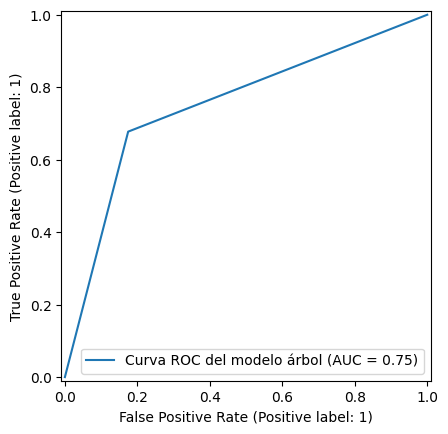

In [115]:
y_pred_val_d = modelo_arbol_d.predict(X_val_d)
RocCurveDisplay.from_predictions(y_val_d, y_pred_val_d, name='Curva ROC del modelo árbol');
print(f'El área bajo la curva ROC del modelo de árbol es: {roc_auc_score(y_val_d, y_pred_val_d):.4f}')

El área bajo la curva ROC del modelo de random forest es: 0.5732


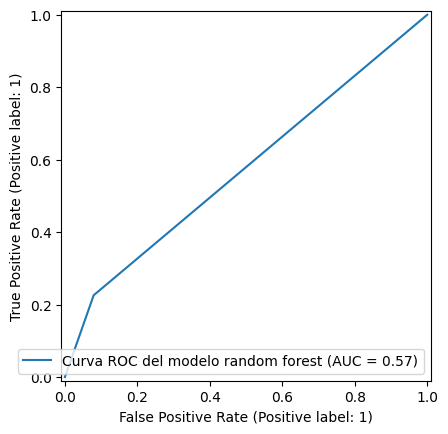

In [116]:
y_pred_val_d = modelo_randomforest_d.predict(X_val_d)
RocCurveDisplay.from_predictions(y_val_d, y_pred_val_d, name='Curva ROC del modelo random forest');
print(f'El área bajo la curva ROC del modelo de random forest es: {roc_auc_score(y_val_d, y_pred_val_d):.4f}')

Curva precisión x sensibilidad y métrica AP

La precisión promedio para distintos valores de sensibilidad en el modelo de árbol es: 0.5509


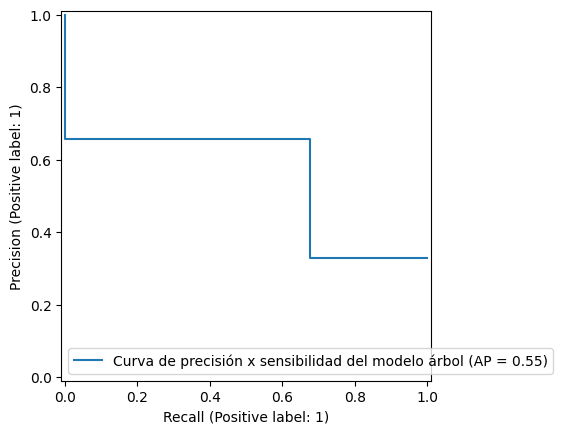

In [117]:
y_pred_val_d = modelo_arbol_d.predict(X_val_d)
PrecisionRecallDisplay.from_predictions(y_val_d, y_pred_val_d, name='Curva de precisión x sensibilidad del modelo árbol');
print(f'La precisión promedio para distintos valores de sensibilidad en el modelo de árbol es: {average_precision_score(y_val_d, y_pred_val_d):.4f}')

La precisión promedio para distintos valores de sensibilidad en el modelo de randomforest es: 0.3870


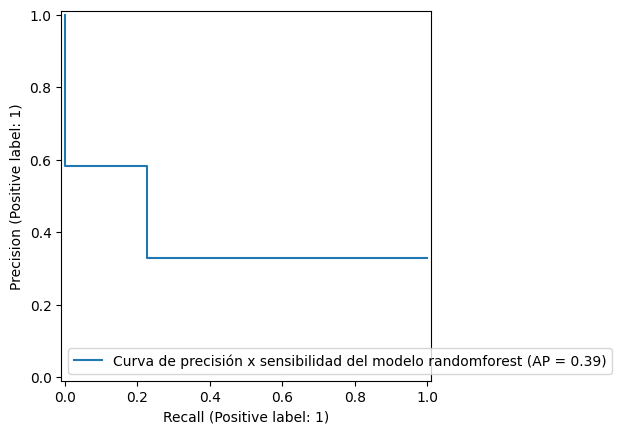

In [118]:
y_pred_val_d = modelo_randomforest_d.predict(X_val_d)
PrecisionRecallDisplay.from_predictions(y_val_d, y_pred_val_d, name='Curva de precisión x sensibilidad del modelo randomforest');
print(f'La precisión promedio para distintos valores de sensibilidad en el modelo de randomforest es: {average_precision_score(y_val_d, y_pred_val_d):.4f}')

#### Informe de métricas

In [119]:
y_pred_val_d = modelo_arbol_d.predict(X_val_d)
reporte = classification_report(y_val_d, y_pred_val_d)
print('Reporte de métricas para el modelo árbol')
print('--'*27)
print(reporte)

Reporte de métricas para el modelo árbol
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.83      0.83        63
           1       0.66      0.68      0.67        31

    accuracy                           0.78        94
   macro avg       0.75      0.75      0.75        94
weighted avg       0.78      0.78      0.78        94



In [120]:
y_pred_val_d = modelo_randomforest_d.predict(X_val_d)
reporte = classification_report(y_val_d, y_pred_val_d)
print('Reporte de métricas para el modelo random forest')
print('--'*27)
print(reporte)

Reporte de métricas para el modelo random forest
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.92      0.80        63
           1       0.58      0.23      0.33        31

    accuracy                           0.69        94
   macro avg       0.65      0.57      0.56        94
weighted avg       0.67      0.69      0.64        94



## <font color='dark'> Validación cruzada</h1>

### Usando KFold

La validación del modelo de clasificación a partir de la separación de los datos en conjuntos de entrenamiento y validación hace que el resultado dependa en gran medida de esta división. Puede suceder que, de forma aleatoria, el patrón de los datos de validación sea diferente al de los datos de entrenamiento, lo que podría llevar a obtener un resultado mucho mejor o mucho peor que la realidad simplemente por suerte o mala suerte.  

Teniendo esto en cuenta, es posible utilizar la **validación cruzada**, una estrategia más consistente y ampliamente utilizada en proyectos de *machine learning*.  

En la validación cruzada, en lugar de separar los datos en entrenamiento y validación una sola vez, se dividen en varias partes de igual tamaño. En cada una de estas divisiones, se usa una parte para validación y todas las demás para entrenamiento. Este proceso se repite hasta que todas las partes hayan sido utilizadas tanto para validación como para entrenamiento.  

Se generará un modelo para cada una de estas divisiones y la evaluación del desempeño se realizará promediando la métrica de cada modelo. Esto elimina la dependencia de la separación de los datos, ya que hay una mayor variación en la selección de los mismos y se obtiene un valor medio.  

Generalmente, se utilizan 5 o 10 partes. Un número mayor no suele ser necesario, ya que implica un procesamiento más costoso, y valores menores ya ayudan a mitigar el problema de la selección de los datos.

<a href="https://ibb.co/KcBtshJR"><img src="https://i.ibb.co/nq4X1mFZ/train-y-validacion.png" alt="train-y-validacion" border="0"></a>

In [121]:
#Se usó el modelo de árbol por tener mejor recall que el modelo random forest
modelo_arbol = DecisionTreeClassifier(max_depth=10, random_state=5)

#Se almacena la forma en que se dividirán los datos
kf = KFold(n_splits=5, shuffle=True, random_state=5)

#Se subdivide, entrena y valida con cada subconjunto de entrenamiento y validación
validacion_cruzada_accuracy = cross_validate(estimator = modelo_arbol, X=X, y=y, cv=kf)
validacion_cruzada_accuracy

{'fit_time': array([0.25102043, 0.25304842, 0.24273634, 0.23775291, 0.2601614 ]),
 'score_time': array([0.00360584, 0.00347281, 0.00343943, 0.00427675, 0.00407982]),
 'test_score': array([0.9127926 , 0.90733885, 0.90755662, 0.91343641, 0.89993467])}

In [122]:
#Se calcula el promedio y desviación estándar de los scores de exactitud
exactitud_promedio = validacion_cruzada_accuracy['test_score'].mean()
exactitud_std = validacion_cruzada_accuracy['test_score'].std()
print(f' En 5 conjuntos de validación, los resultados de exactitud del modelo de arbol fueron:\n',
      f'Exactitud promedio: {exactitud_promedio:.4f}.\n',
      f'Desviación estándar: {exactitud_std:.4f}.\n',
      f'Intervalo del confianza: ({(exactitud_promedio - 2*exactitud_std):.4f};{min(exactitud_promedio + 2*exactitud_std,1):.4f})')

 En 5 conjuntos de validación, los resultados de exactitud del modelo de arbol fueron:
 Exactitud promedio: 0.9082.
 Desviación estándar: 0.0049.
 Intervalo del confianza: (0.8985;0.9179)


### Validación cruzada con sensibilidad
Se puede especificar la métrica calculada en el método [cross_validate](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) mediante el parámetro scoring, el cuál recibe una sola métrica en forma de [cadena de texto](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-string-names) o muchas métricas en forma de tupla, lista o diccionario.

In [123]:
def intervaloconfianza(resultado, metrica):
  score_name = f'test_{metrica}'
  metrica_promedio = resultado[score_name].mean()
  metrica_std = resultado[score_name].std()
  return f'Intervalo del confianza para {metrica} es: ({(metrica_promedio - 2*metrica_std):.4f};{min(metrica_promedio + 2*metrica_std,1):.4f})'

In [124]:
#Se calcula la métrica recall cuyos valores figurarán en la clave 'TEST_SCORE'.
modelo_arbol = DecisionTreeClassifier(max_depth=10, random_state=5)
kf = KFold(n_splits=5, shuffle=True, random_state=5)
validacion_cruzada_recall = cross_validate(estimator = modelo_arbol, X=X, y=y, cv=kf, scoring=['recall'])
validacion_cruzada_recall

{'fit_time': array([0.27863741, 0.26191378, 0.2447691 , 0.24807072, 0.26146388]),
 'score_time': array([0.00662017, 0.00596237, 0.00595617, 0.00665402, 0.00610304]),
 'test_recall': array([0.02642008, 0.01856436, 0.0196802 , 0.0156658 , 0.02427746])}

In [125]:
intervaloconfianza(validacion_cruzada_recall, 'recall')

'Intervalo del confianza para recall es: (0.0131;0.0287)'

Se calcularon las siguientes métricas con la validación cruzada: Exactitud,Recall, Precisión y F1-score.
Para ello, se tomó como referencias los ejemplos de la [documentación](https://scikit-learn.org/stable/modules/model_evaluation.html#using-multiple-metric-evaluation) y los [nombres de cada métrica](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-string-names).

In [126]:
metricas = ['accuracy', 'recall', 'precision', 'f1']
modelo_arbol = DecisionTreeClassifier(max_depth=10, random_state=5)
kf = KFold(n_splits=5, shuffle=True, random_state=5)

for i in metricas:
  vc_metrica = cross_validate(estimator = modelo_arbol, X=X, y=y, cv=kf, scoring={i:i})
  print(intervaloconfianza(vc_metrica, i))

Intervalo del confianza para accuracy es: (0.8985;0.9179)
Intervalo del confianza para recall es: (0.0131;0.0287)
Intervalo del confianza para precision es: (0.2012;0.2485)
Intervalo del confianza para f1 es: (0.0250;0.0514)


### Estratificando los datos
Cuando las clases de la variable de respuesta tienen cantidades desequilibradas, es necesario mantener esa proporción en los conjuntos de datos usados en la validación cruzada.

In [127]:
datos.moroso.value_counts()

,count
moroso,
0,49309
1,4716


In [128]:
metricas = ['accuracy', 'recall', 'precision', 'f1']
modelo_arbol = DecisionTreeClassifier(max_depth=10, random_state=5)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

for i in metricas:
  vc_metrica = cross_validate(estimator = modelo_arbol, X=X, y=y, cv=skf, scoring={i:i})
  print(intervaloconfianza(vc_metrica, i))

Intervalo del confianza para accuracy es: (0.9033;0.9107)
Intervalo del confianza para recall es: (0.0210;0.0359)
Intervalo del confianza para precision es: (0.1750;0.3040)
Intervalo del confianza para f1 es: (0.0393;0.0619)


### Desafío - aula 3
Para realizar los desafíos, descarga la base de datos desde [este enlace](https://github.com/alura-es-cursos/2162-clasificacion-validacion-de-modelos-y-metricas/blob/desafios/diabetes.csv).
1. En el proceso de validación cruzada, se generan diferentes modelos para cada división realizada en los datos y, en consecuencia, diferentes valores de métricas de evaluación. Para encontrar un resultado promedio de las métricas, se puede construir un intervalo de confianza a partir de la media y la desviación estándar de las métricas. Crea una función para calcular el intervalo de confianza de los resultados de una validación cruzada con 2 desviaciones estándar. La función necesita 2 parámetros: uno para recibir una lista con los resultados de las métricas de la validación cruzada y otro para recibir el nombre del algoritmo. Para generar el intervalo de confianza, extrae la media de los resultados de la lista y la desviación estándar. El intervalo de confianza debe ser presentado en un print con el valor mínimo siendo la media restada de 2 desviaciones estándar y el valor máximo siendo la media sumada de 2 desviaciones estándar. Ejemplo de retorno de la función:
```Python
Intervalo de confianza ("nombre del modelo"): ["valor mínimo del intervalo", "valor máximo del intervalo"]
```
2. KFold es la estrategia más simple de validación cruzada, que permite la división aleatoria de los datos en k partes, siendo utilizada una parte para validación y el resto para entrenamiento del modelo. El proceso de creación de modelos se repite hasta que todas las partes son utilizadas como validación. Sabiendo esto, evalúa el desempeño de los modelos con un intervalo de confianza utilizando la validación cruzada con el método KFold, usando 10 partes, con el uso del parámetro n_splits y mezclando los datos antes de la separación con el parámetro shuffle. Usa el método cross_val_score que no retorna el tiempo de ejecución, solo las métricas.

3. En el proceso de división de datos con el KFold aleatorio, puede ser que la proporción de cada categoría de la variable objetivo no se mantenga en cada una de las partes de los datos. Para mantener esa proporción en cada una de las partes, podemos utilizar el KFold estratificado, haciendo que el proceso de validación de datos sea mucho más consistente. Evalúa el desempeño de los modelos con un intervalo de confianza utilizando la validación cruzada (cross_val_score) con el método StratifiedKFold, usando el parámetro n_splits y mezclando los datos antes de la separación con el parámetro shuffle y evaluando la métrica F1-Score usando el parámetro scoring.

4. En conjuntos de datos con pocos registros (pocas filas), las estrategias de separación de los datos para validación pueden hacer que quede poca información en los datos de entrenamiento, haciendo que el modelo no comprenda bien el patrón de los datos. El LeaveOneOut es una estrategia para sortear este problema, utilizando solo un registro como dato de validación. Evalúa el desempeño de los modelos utilizando la validación cruzada (cross_val_score) con el método [LeaveOneOut](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html).

#### Función para el cálculo del intervalo de confianza
Se modificó considerando que el método [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) genera un array correspondiente a una sola métrica.

In [129]:
def intervaloconfianza(resultado, metrica):
  metrica_promedio = resultado.mean()
  metrica_std = resultado.std()
  return f'Intervalo del confianza para {metrica} es: ({max(metrica_promedio - 2*metrica_std,0):.4f};{min(metrica_promedio + 2*metrica_std,1):.4f})'

In [130]:
#ModeloML y métricas
metricas = ['accuracy', 'recall', 'precision', 'f1']
modelos = {'arbol':modelo_arbol_d,'random forest':modelo_randomforest_d}

####Método de validación cruzada con KFold

In [131]:
kf = KFold(n_splits=10, shuffle=True, random_state=5)

In [132]:
#Resultados de la validación
for clave, valor in modelos.items():
  print(f'Resultados de validación cruzada para el modelo de {clave} usando Kfold')
  print('-'*30)
  for j in metricas:
    vc_metrica = cross_val_score(estimator = valor, X=X_d, y=y_d, cv=kf, scoring=j)
    print(intervaloconfianza(vc_metrica, j))

Resultados de validación cruzada para el modelo de arbol usando Kfold
------------------------------
Intervalo del confianza para accuracy es: (0.5337;0.8684)
Intervalo del confianza para recall es: (0.2846;0.7423)
Intervalo del confianza para precision es: (0.2171;0.9558)
Intervalo del confianza para f1 es: (0.3029;0.7500)
Resultados de validación cruzada para el modelo de random forest usando Kfold
------------------------------
Intervalo del confianza para accuracy es: (0.6078;0.7553)
Intervalo del confianza para recall es: (0.0000;0.5301)
Intervalo del confianza para precision es: (0.0759;1.0000)
Intervalo del confianza para f1 es: (0.0079;0.5688)


####Método de validación cruzada con StratifiedKFold

In [133]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=5)

In [134]:
#Resultados de la validación
for clave, valor in modelos.items():
  print(f'Resultados de validación cruzada para el modelo de {clave} usando StratifiedKfold')
  print('-'*30)
  for j in metricas:
    vc_metrica = cross_val_score(estimator = valor, X=X_d, y=y_d, cv=skf, scoring=j)
    print(intervaloconfianza(vc_metrica, j))

Resultados de validación cruzada para el modelo de arbol usando StratifiedKfold
------------------------------
Intervalo del confianza para accuracy es: (0.6283;0.7671)
Intervalo del confianza para recall es: (0.1206;0.9179)
Intervalo del confianza para precision es: (0.3910;0.7412)
Intervalo del confianza para f1 es: (0.2717;0.7462)
Resultados de validación cruzada para el modelo de random forest usando StratifiedKfold
------------------------------
Intervalo del confianza para accuracy es: (0.6068;0.7571)
Intervalo del confianza para recall es: (0.0000;0.4624)
Intervalo del confianza para precision es: (0.0729;0.8973)
Intervalo del confianza para f1 es: (0.0000;0.5949)


####Método de validación cruzada con LeaveOneOut
En este método, se valida el modelo en cada dato del conjunto de entrenamiento (n° validacion = 1). Por tanto:
- No se puede generar una matriz de confusión con 1 solo dato de validación.
- La desviación estándar sería muy alta debido a que los puntajes de exactitud serían únicamente ceros o unos, generando el intervalo de confianza (0; 1).

Por todo lo anterior, se obtuvo únicamente la exactitud promedio de cada modelo usando la validación cruzada con el método LeaveOneOut.

In [135]:
loo = LeaveOneOut()

In [136]:
#Resultados de la validación
for clave, valor in modelos.items():
  print(f'Resultados de validación cruzada para el modelo de {clave} usando LeaveOneOut')
  print('-'*30)
  vc_metrica = cross_val_score(estimator = valor, X=X_d, y=y_d, cv=loo)
  print(f'Exactitud media ({clave}): {vc_metrica.mean()}')

Resultados de validación cruzada para el modelo de arbol usando LeaveOneOut
------------------------------
Exactitud media (arbol): 0.7085561497326203
Resultados de validación cruzada para el modelo de random forest usando LeaveOneOut
------------------------------
Exactitud media (random forest): 0.6844919786096256


## <font color='dark'>Balanceo de los datos</h1>

### Oversampling

https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html#id1

In [137]:
#Proporción de categorías en el conjunto de entrenamiento y validación
y.value_counts(normalize=True)*100

,proportion
moroso,
0,91.269789
1,8.730211


In [138]:
#Se nombra el método de balanceo en la variable sm
sm = SMOTE(random_state=42)

#Se balancean el conjunto de datos de entrenamiento y validación con SMOTE
X_balanceado, y_balanceado = sm.fit_resample(X, y)

In [139]:
#Se vuelve a crear la función intervalodeconfianza que recibe el array generado con cross_validate
def intervaloconfianza(resultado, metrica):
  score_name = f'test_{metrica}'
  metrica_promedio = resultado[score_name].mean()
  metrica_std = resultado[score_name].std()
  return f'Intervalo del confianza para {metrica} es: ({(metrica_promedio - 2*metrica_std):.4f};{min(metrica_promedio + 2*metrica_std,1):.4f})'

In [140]:
#Informe de métricas de la validación cruzada para el conjunto de datos balanceado
metricas = ['accuracy', 'recall', 'precision', 'f1']
modelo_arbol = DecisionTreeClassifier(max_depth=10, random_state=5)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

for i in metricas:
  vc_metrica = cross_validate(estimator = modelo_arbol, X=X_balanceado, y=y_balanceado, cv=skf, scoring={i:i})
  print(intervaloconfianza(vc_metrica, i))

Intervalo del confianza para accuracy es: (0.7670;0.7887)
Intervalo del confianza para recall es: (0.6921;0.7579)
Intervalo del confianza para precision es: (0.7958;0.8259)
Intervalo del confianza para f1 es: (0.7495;0.7813)


### Pipeline para validación

In [141]:
#Creación de un pipeline para entrenar el modelo de arbol con datos balanceados, para que aprenda de ambas clases
modelo_arbol = DecisionTreeClassifier(max_depth=10, random_state=5)
pipeline = imbpipeline(steps=[('balanceo oversample', SMOTE(random_state=42)), ('modelo', modelo_arbol)]) #Solo se contruye

In [142]:
#Informe de métricas de la validación cruzada para el conjunto de datos desbalanceados, para obtener resultados más realistas
metricas = ['accuracy', 'recall', 'precision', 'f1']
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

for i in metricas:
  vc_metrica = cross_validate(estimator = pipeline, X=X, y=y, cv=skf, scoring={i:i})#Se ejecuta el pipeline que usará SMOTE unicamente durante el entrenamiento.
  print(intervaloconfianza(vc_metrica, i))

Intervalo del confianza para accuracy es: (0.7435;0.8094)
Intervalo del confianza para recall es: (0.1790;0.3004)
Intervalo del confianza para precision es: (0.1062;0.1290)
Intervalo del confianza para f1 es: (0.1389;0.1756)


### Undersampling

https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.NearMiss.html

In [144]:
#Creación de un pipeline para entrenar el modelo de arbol con datos balanceados, para que aprenda de ambas clases
modelo_arbol = DecisionTreeClassifier(max_depth=10, random_state=5)
pipeline = imbpipeline(steps=[('balanceo undersample', NearMiss(version=3)), ('modelo', modelo_arbol)]) #Solo se contruye

In [145]:
#Informe de métricas de la validación cruzada para el conjunto de datos desbalanceados, para obtener resultados más realistas
metricas = ['accuracy', 'recall', 'precision', 'f1']
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

for i in metricas:
  vc_metrica = cross_validate(estimator = pipeline, X=X, y=y, cv=skf, scoring={i:i})#Se ejecuta el pipeline que usará NEARMISS unicamente durante el entrenamiento.
  print(intervaloconfianza(vc_metrica, i))

Intervalo del confianza para accuracy es: (0.4723;0.5486)
Intervalo del confianza para recall es: (0.6289;0.6996)
Intervalo del confianza para precision es: (0.1078;0.1161)
Intervalo del confianza para f1 es: (0.1864;0.1968)


### Probando el modelo

              precision    recall  f1-score   support

           0       0.94      0.48      0.64      7397
           1       0.11      0.70      0.20       707

    accuracy                           0.50      8104
   macro avg       0.53      0.59      0.42      8104
weighted avg       0.87      0.50      0.60      8104



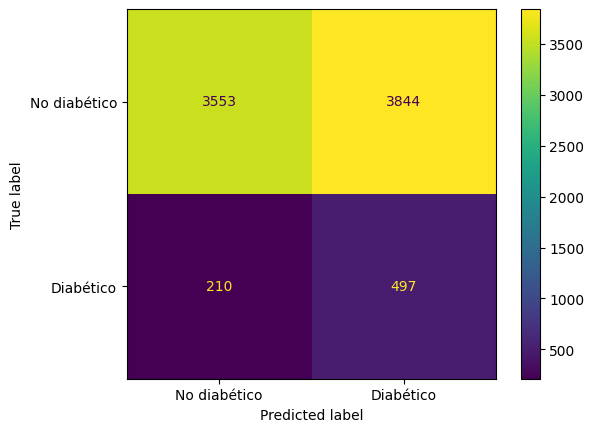

In [147]:
#Entrenamos el modelo de arbol siguiendo los pasos del pipeline y con todos los datos de entrenamiento (X, y)
modelo_arbol = pipeline.fit(X, y)

#Predicción de y a partir del X_test
y_pred_test = modelo_arbol.predict(X_test)

#Imprimimos el reporte de métricas de clasificación
print(classification_report(y_test, y_pred_test))

#Imprimimos la matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, display_labels=['No moroso','Moroso']);

### Desafío 1 - aula 4
Como desafío, utiliza el algoritmo [SMOTEENN](https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTEENN.html), que combina el oversampling con SMOTE y el undersampling con el ENN (Edited Nearest Neighbours), para balancear los datos y observa los resultados obtenidos por el modelo usando el pipeline y la validación cruzada.

In [150]:
#Creación de un pipeline para entrenar el modelo de arbol con datos balanceados, para que aprenda de ambas clases
modelo_arbol = DecisionTreeClassifier(max_depth=10, random_state=5)
pipeline = imbpipeline(steps=[('balanceo mixto', SMOTEENN(random_state=42)), ('modelo', modelo_arbol)]) #Solo se contruye

In [151]:
#Informe de métricas de la validación cruzada para el conjunto de datos desbalanceados, para obtener resultados más realistas
metricas = ['accuracy', 'recall', 'precision', 'f1']
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

for i in metricas:
  vc_metrica = cross_validate(estimator = pipeline, X=X, y=y, cv=skf, scoring={i:i})#Se ejecuta el pipeline que usará SMOTENN unicamente durante el entrenamiento.
  print(intervaloconfianza(vc_metrica, i))

Intervalo del confianza para accuracy es: (0.7157;0.7660)
Intervalo del confianza para recall es: (0.3033;0.3811)
Intervalo del confianza para precision es: (0.1210;0.1374)
Intervalo del confianza para f1 es: (0.1778;0.1970)


### Desafío 2 - aula 4

Para realizar los desafíos, descarga la base de datos desde [este enlace](https://github.com/alura-es-cursos/2162-clasificacion-validacion-de-modelos-y-metricas/blob/desafios/diabetes.csv).

1. El desbalanceo de los datos de la variable objetivo puede hacer que el modelo se incline a acertar los patrones de solo la categoría que tiene mayor cantidad, haciendo necesario en algunos casos un tratamiento específico de balanceo de datos. La etapa inicial es identificar si existe o no el desbalanceo de datos en la variable objetivo. Por eso, verifica la proporción de datos de la variable objetivo del conjunto de datos de diabetes. Este análisis puede hacerse a partir del porcentaje de datos, utilizando el método value_counts(normalize=True) o con la utilización de un gráfico de conteo, usando el gráfico countplot de la biblioteca seaborn para entender si hay un desbalanceo de datos.

2. Al realizar el balanceo de datos en una validación cruzada, es necesario utilizar un pipeline, para que los datos de validación no sean balanceados, manteniéndose en el estándar de los datos del mundo real. Utiliza un pipeline que contenga el ajuste del modelo y el balanceo de los datos usando el oversampling con SMOTE, obteniendo la media del F1-Score de una validación cruzada con StratifiedKFold.

3. Además del oversampling, es posible utilizar la estrategia de undersampling para hacer el balanceo de los datos. A pesar de ser estrategias distintas, ambas requieren de un pipeline por tratarse de balanceo de datos en una validación cruzada. Utiliza un pipeline que contenga el ajuste del modelo y el balanceo de los datos usando el undersampling con NearMiss en su versión 3, obteniendo la media del F1-Score de una validación cruzada con StratifiedKFold.

4. Después de realizar diversas análisis y mejorar el rendimiento de los modelos, llega la etapa final, que consiste en seleccionar el modelo con mejor rendimiento y hacer la evaluación final en un conjunto de datos de prueba, que no ha sido visto durante el proceso de entrenamiento y validación. Elige el modelo que obtuvo el mejor rendimiento al comparar las estrategias de oversampling y undersampling y entrena un modelo usando todos los datos con la mejor estrategia. Realiza la evaluación del modelo usando los datos de prueba que fueron separados al inicio de los desafíos, obteniendo el informe de métricas y matriz de confusión.

#### Conteo de categorías de la variable de respuesta

In [153]:
y_d.value_counts(normalize=True)*100

,proportion
diabetes,
0,67.112299
1,32.887701


In [155]:
#Se vuelve a crear la función intervalodeconfianza que recibe el array generado con cross_val_score
def intervaloconfianza(resultado, metrica):
  metrica_promedio = resultado.mean()
  metrica_std = resultado.std()
  return f'Intervalo del confianza para {metrica} es: ({max(metrica_promedio - 2*metrica_std,0):.4f};{min(metrica_promedio + 2*metrica_std,1):.4f})'

In [156]:
#Métricas
metricas = ['accuracy', 'recall', 'precision', 'f1']

#### Oversampling

In [ ]:
#Pipelines
pipeline_arbol = imbpipeline(steps=[('balanceo oversample', SMOTE(random_state=42)), ('modelo', modelo_arbol_d)])
pipeline_randomforest = imbpipeline(steps=[('balanceo oversample', SMOTE(random_state=42)), ('modelo', modelo_randomforest_d)])
pipelines = {'arbol':pipeline_arbol,'random forest':pipeline_randomforest}

In [157]:
#Informe de métricas de la validación cruzada para el conjunto de datos desbalanceados, para obtener resultados más realistas
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
#Resultados de la validación
for clave, valor in pipelines.items():
  print(f'Resultados de validación cruzada para el modelo {clave} entrenado con datos balanceados usando SMOTE')
  print('-'*30)
  for j in metricas:
    vc_metrica = cross_val_score(estimator = valor, X=X_d, y=y_d, cv=skf, scoring=j)
    print(intervaloconfianza(vc_metrica, j))

Resultados de validación cruzada para el modelo arbol entrenado con datos balanceados usando SMOTE
------------------------------
Intervalo del confianza para accuracy es: (0.5498;0.7439)
Intervalo del confianza para recall es: (0.3112;1.0000)
Intervalo del confianza para precision es: (0.3789;0.5997)
Intervalo del confianza para f1 es: (0.4461;0.6460)
Resultados de validación cruzada para el modelo random forest entrenado con datos balanceados usando SMOTE
------------------------------
Intervalo del confianza para accuracy es: (0.6264;0.7317)
Intervalo del confianza para recall es: (0.5134;0.9806)
Intervalo del confianza para precision es: (0.4502;0.5767)
Intervalo del confianza para f1 es: (0.5367;0.6672)


#### Undersampling

In [159]:
#Pipelines
pipeline_arbol = imbpipeline(steps=[('balanceo undersample', NearMiss(version=3)), ('modelo', modelo_arbol_d)])
pipeline_randomforest = imbpipeline(steps=[('balanceo undersample', NearMiss(version=3)), ('modelo', modelo_randomforest_d)])
pipelines = {'arbol':pipeline_arbol,'random forest':pipeline_randomforest}

In [160]:
#Informe de métricas de la validación cruzada para el conjunto de datos desbalanceados, para obtener resultados más realistas
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
#Resultados de la validación
for clave, valor in pipelines.items():
  print(f'Resultados de validación cruzada para el modelo {clave} entrenado con datos balanceados usando NearMiss')
  print('-'*30)
  for j in metricas:
    vc_metrica = cross_val_score(estimator = valor, X=X_d, y=y_d, cv=skf, scoring=j)
    print(intervaloconfianza(vc_metrica, j))

Resultados de validación cruzada para el modelo arbol entrenado con datos balanceados usando NearMiss
------------------------------
Intervalo del confianza para accuracy es: (0.4957;0.6916)
Intervalo del confianza para recall es: (0.3888;0.6698)
Intervalo del confianza para precision es: (0.3185;0.5085)
Intervalo del confianza para f1 es: (0.3787;0.5442)
Resultados de validación cruzada para el modelo random forest entrenado con datos balanceados usando NearMiss
------------------------------
Intervalo del confianza para accuracy es: (0.6568;0.7551)
Intervalo del confianza para recall es: (0.5108;0.9018)
Intervalo del confianza para precision es: (0.4831;0.6076)
Intervalo del confianza para f1 es: (0.5484;0.6722)


####Evaluación final del modelo
Se evaluará el modelo Random Forest empleando la técnica de balanceo undersampling. Toda vez que con obtuvo el mejor intervalo de confianza para la métrica F1.

In [161]:
modelo_randomforest_d

RandomForestClassifier(max_depth=2, random_state=2)

              precision    recall  f1-score   support

           0       0.89      0.62      0.73        13
           1       0.55      0.86      0.67         7

    accuracy                           0.70        20
   macro avg       0.72      0.74      0.70        20
weighted avg       0.77      0.70      0.71        20



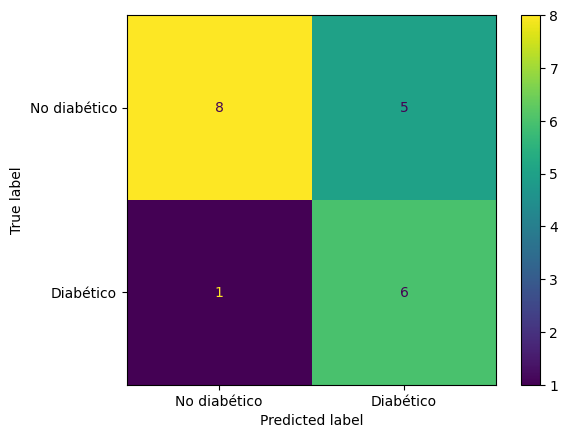

In [162]:
#Pipeline de RandomForest y undersampling
pipeline_randomforest = imbpipeline(steps=[('balanceo undersample', NearMiss(version=3)), ('modelo', modelo_randomforest_d)])

#Entrenamos el modelo de arbol siguiendo los pasos del pipeline y con todos los datos de entrenamiento (X, y)
modelo_randomforest_d = pipeline_randomforest.fit(X_d, y_d)

#Predicción de y a partir del X_test
y_pred_test_d = modelo_randomforest_d.predict(X_test_d)

#Imprimimos el reporte de métricas de clasificación
print(classification_report(y_test_d, y_pred_test_d))

#Imprimimos la matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_test_d, y_pred_test_d, display_labels=['No diabético','Diabético']);